In [1]:
cd /home

/home


In [5]:
import tensorflow as tf 
import matplotlib.pyplot as plt

from core.data import preprocess_and_save, get_companions, create_tf_dataset
from tensorflow.keras.optimizers import Adam
from core.losses import reduce_moments
from core.model import create_model
from core.engine import preprocess


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%%time
window_size = 15
data_path = './data/HCI/'
table, cube, psf, rot_angles, backmoments = preprocess(data_path)
dataset_name = data_path.split('/')[-2]
dataset_name

CPU times: user 63.2 ms, sys: 71.4 ms, total: 135 ms
Wall time: 135 ms


'HCI'

In [7]:
row = table.iloc[0]
print(row)

x            97.736452
y            97.652952
flux         15.454206
fwhm_mean     3.057851
snr           2.315319
Name: 0, dtype: float64


In [8]:
companion = get_companions(cube, 
                           x=row['x'], 
                           y=row['y'], 
                           window_size=window_size)
psf       = get_companions(psf, 
                           x=psf.shape[-1]//2, 
                           y=psf.shape[-1]//2, 
                           window_size=window_size)

2023-08-16 18:39:20.122549: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 18:39:20.129047: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 18:39:20.219659: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To ena

In [29]:
loader, input_shape = create_tf_dataset(psf, companion, batch_size=1, repeat=1)

In [30]:
model = create_model(input_shape=input_shape, init_flux=row['flux'])

In [31]:
model.compile(backmoments=backmoments, 
              fwhm=row['fwhm_mean'], 
              optimizer=Adam(1e0))

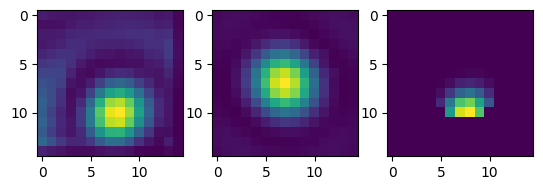

In [32]:
fig, axes = plt.subplots(1, 3)
for x, y in loader.take(1):
    y_pred = model(x)
    
    
    residuals = reduce_moments(y, y_pred, backmoments, 
                               fwhm=row['fwhm_mean'], debug=True)
    
    axes[1].imshow(y_pred[0,0,...,0])
    axes[0].imshow(y[0,0,...,0])
    
    axes[2].imshow(residuals[0, 0,...,0])